In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)


### 1. Загрузка данных и первичная очистка


In [2]:
df = pd.read_csv('pass-tr.csv')

# Удаляем полные дубликаты
df_clean = df.drop_duplicates()

# Удаляем пустые строки в важных колонках
df_clean = df_clean.dropna(subset=['Transaction', 'Amount'])

# Преобразуем дату
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y', errors='coerce')
df_clean = df_clean.dropna(subset=['Date'])

# Логика знаков: Если Transaction 'W' (снятие), то умножаем на -1
df_clean['Real_amount'] = np.where(df_clean['Transaction'] == 'W', df_clean['Amount'] * -1, df_clean['Amount'])

# Сортируем по дате и сбрасываем индекс
df_clean = df_clean.sort_values(by='Date').reset_index(drop=True)

print(f"Данные до очистки. Строк: {len(df)}\nДанные после очистки. Строк: {len(df_clean)}")
df_clean.head()


Данные до очистки. Строк: 5170
Данные после очистки. Строк: 5121


,id,Depositor Name,Transaction,Amount,Date,Entered,Reel,Position,Box,Pic_No,Name,Gender/Inst,Acct No,City,State,Notice Given,Real_amount
0,230154,George Williams,D,1.00,1866-01-17,Y,23,154,3.00,3474,George Williams,M,21.00,Savannah,GA,NaN,1.00
1,252281,Home Mission Society,D,100.00,1867-01-17,Y,25,2281,1.00,2279,Home Mission Society,I,454.00,Baltimore,MD,NaN,100.00
2,211004,Lizzie McNiel,D,0.21,1867-06-11,Y,21,1004,2.00,1054,Lizzie McNiel,F,723.00,Mobile,AL,NaN,0.21
3,211010,Mary McNiel,D,0.50,1867-06-11,Y,21,1010,2.00,1050,Mary McNiel,F,721.00,Mobile,AL,NaN,0.50
4,220076,John Johnson,D,0.50,1867-06-11,Y,22,76,2.00,1048,John Johnson,M,720.00,Mobile,AL,NaN,0.50


### 2. Анализ баланса клиентов

In [3]:
# Группируем по имени и считаем сумму
df_rich_clients = df_clean.groupby('Name')['Real_amount'].sum().sort_values(ascending=False).reset_index()

print("Топ-5 богатых:")
df_rich_clients.head()


Топ-5 богатых:


,Name,Real_amount
0,Eliza J Anderson,2240.51
1,F R Faubert,1645.20
2,John Pierson Carter,1600.00
3,PW Anderson,1547.45
4,Henry and Patsy Burdy,1033.27


In [4]:
print("Топ-5 Должников:")
df_rich_clients.tail()

Топ-5 Должников:


,Name,Real_amount
505,Caroline Holmes,-68.00
506,Ladies Good Samaritan Society,-70.81
507,A.R. Fowler,-124.25
508,John C Underwood,-345.50
509,Alfred McCarock,-1214.38


### 3. Анализ 'Набега'


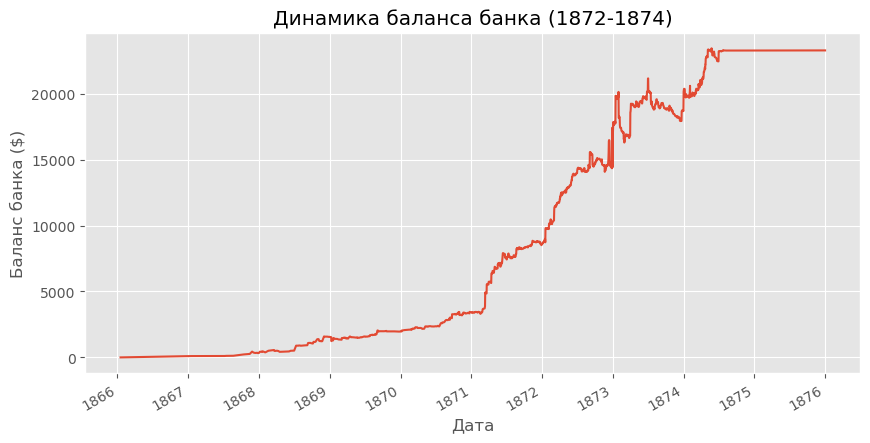

Итоговый баланс банка: $23286.439999999977


In [5]:
# Считаем итоговый баланс
bank_balance_history = df_clean.groupby('Date')['Real_amount'].sum().cumsum()

# График
bank_balance_history.plot(figsize=(10,5), title='Динамика баланса банка (1872-1874)', grid=True)
plt.xlabel('Дата')
plt.ylabel('Баланс банка ($)')
plt.show()

print(f"Итоговый баланс банка: ${bank_balance_history.iloc[-1]}")


### 4. Географический анализ (Города)


In [6]:
# Считаем деньги по городам
city_money = df_clean.groupby('City')['Real_amount'].sum().sort_values(ascending=False).reset_index()
city_money.rename(columns={'Real_amount': 'Balance'}, inplace=True)

# Считаем уникальных клиентов по городам
city_clients = df_clean.groupby('City')['Name'].nunique().reset_index()
city_clients.rename(columns={'Name': 'Unique_clients'}, inplace=True)


city_stats = pd.merge(city_money, city_clients, on='City', how='left')

city_stats.head()


,City,Balance,Unique_clients
0,Washington,6215.78,43
1,New York,2914.83,4
2,Norfolk,2072.41,88
3,Lexington,1930.48,41
4,New Bern,1768.23,4


### 5. Анализ лояльности (Lifetime)


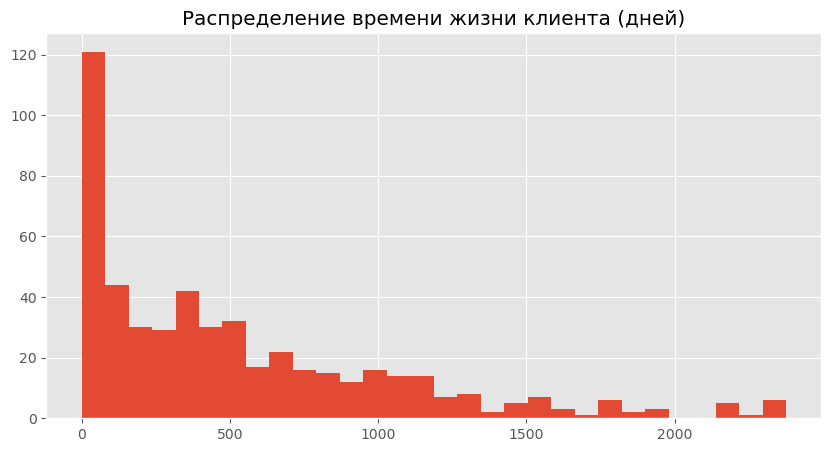

In [7]:
# Находим дату первой и последней транзакции
time_min = df_clean.groupby('Name')['Date'].min().reset_index()
time_min.rename(columns={'Date': 'Date_min'}, inplace=True)

time_max = df_clean.groupby('Name')['Date'].max().reset_index()
time_max.rename(columns={'Date': 'Date_max'}, inplace=True)

client_lifetime = pd.merge(time_min, time_max, on='Name', how='left')

client_lifetime['Life_time'] = client_lifetime['Date_max'] - client_lifetime['Date_min']
client_lifetime['Life_time'] = client_lifetime['Life_time'].dt.days

client_lifetime = client_lifetime.sort_values(by='Life_time', ascending=False).reset_index()

# Гистограмма
client_lifetime['Life_time'].hist(bins=30, figsize=(10,5))
plt.title('Распределение времени жизни клиента (дней)')
plt.show()


In [8]:
client_lifetime.head()

,index,Name,Date_min,Date_max,Life_time
0,200,Isaiah Nichols,1867-07-01,1874-01-01,2376
1,14,Alexander Lewis,1867-07-01,1874-01-01,2376
2,132,Frances Barey,1867-07-01,1874-01-01,2376
3,88,Daughters of Wesley,1869-07-27,1876-01-01,2349
4,374,Patrick Smith,1868-01-06,1874-05-26,2332


### 6. Активность vs Богатство (Scatter Plot)


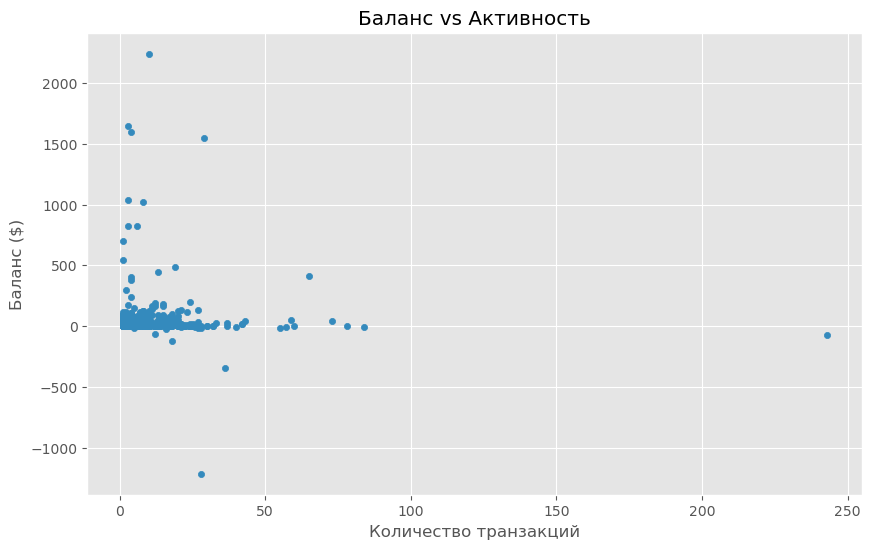

In [9]:
# Считаем количество транзакций
tx_count = df_clean.groupby('Name')['Transaction'].count().reset_index()
tx_count.rename(columns={'Transaction': 'tx_count'}, inplace=True)

df_balance = df_rich_clients.reset_index()

rfm_data = pd.merge(df_balance, tx_count, on='Name', how='left')

# Строим график
rfm_data.plot(kind='scatter', x='tx_count', y='Real_amount', figsize=(10,6), title='Баланс vs Активность')
plt.xlabel('Количество транзакций')
plt.ylabel('Баланс ($)')
plt.show()


### 7. Гендерный анализ


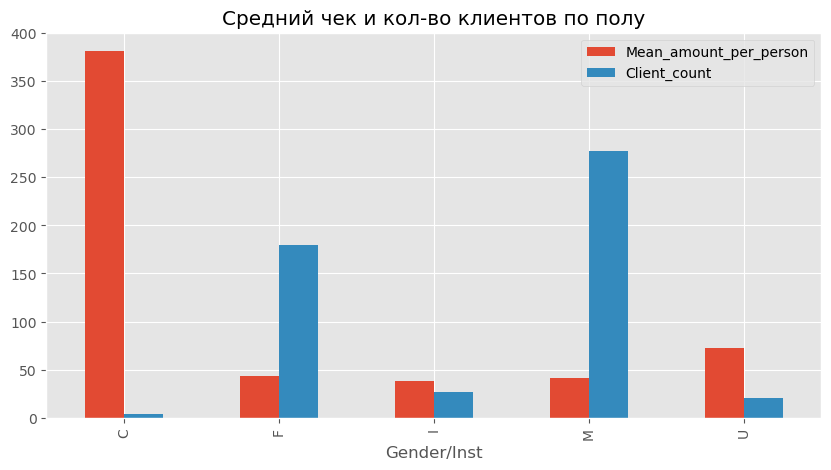

In [10]:
# Считаем метрики
gender_clients = df_clean.groupby('Gender/Inst')['Name'].nunique().reset_index()
gender_sum = df_clean.groupby('Gender/Inst')['Real_amount'].sum().reset_index()

df_gender = pd.merge(gender_sum, gender_clients, on='Gender/Inst', how='left')

# Считаем среднее на человека
df_gender['Mean_amount_per_person'] = df_gender['Real_amount'] / df_gender['Name']

df_gender = df_gender.set_index('Gender/Inst')
df_gender.rename(columns={'Name': 'Client_count'}, inplace=True)

# График
df_gender[['Mean_amount_per_person', 'Client_count']].plot(kind='bar', figsize=(10, 5), title='Средний чек и кол-во клиентов по полу')
plt.show()


In [11]:
df_gender

,Real_amount,Client_count,Mean_amount_per_person
Gender/Inst,,,
C,1525.16,4,381.29
F,7758.47,180,43.10
I,1036.12,27,38.37
M,11386.22,277,41.11
U,1527.44,21,72.74
